# Growth forms coverage

We extracted growth form information (tree/shrub/herb) from TRY (Trait-ID 42) to each iNaturalist observation and estimated the coverage of each growth form for all sPlotOpen plots. We chose the most commonly used classification for each species. The average tree/shrub/herb coverage was then calculated for each grid cell and the these means correlated. 

This section covers:

- Link growth form information to iNaturalist observations
- Calculate coverage
- Plot coverage
- Compare to sPlot life form coverage

In [ ]:
# packages
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

## Link growth form information to iNaturalist observations

In [3]:
iNat = pd.read_csv("iNat_TRY_log.csv")

In [4]:
life_forms = pd.read_csv("TRY/Life_Forms/19233.txt", sep = "\t", encoding="iso-8859-1", 
                      usecols = ["AccSpeciesName", "SpeciesName", "TraitID", "TraitName", "OrigValueStr"],
                     dtype={'TraitID': float})


/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
growth_forms = life_forms[life_forms["TraitID"]==42.0]

In [6]:
growth_forms = growth_forms.dropna(subset=["OrigValueStr"])

Define the variations of growth form terms:

In [7]:
search_terms_tree = ["tree", "Tree", "TREE", "seedling", "hardwood", "softwood", "Hardwood", "Softwood"]
search_terms_herb = ["herb","Herb", "HERB","graminoid", "Graminoid","GRAMINOID", "Forb","forb", 
                     "Grass","grass", "GRASS", "sedge","SEDGE", "fern", "Fern", "FERN"]
search_terms_shrub = ["shrub","Shrub", "SHRUB", "seedling","vine", "Vine", "VINE", "liana", "Liana", "LIANA"]

Add 1 for ```is_tree```, ```is_shrub```, and ```is_herb```, 0 if not:

In [8]:
growth_forms['is_tree'] = (growth_forms["OrigValueStr"]=="T") | growth_forms['OrigValueStr'].str.contains('|'.join(search_terms_tree))

growth_forms['is_tree'] = growth_forms['is_tree'].astype(int)

In [9]:
growth_forms['is_shrub'] = (growth_forms["OrigValueStr"]=="S") | (growth_forms["OrigValueStr"]=="L") | growth_forms['OrigValueStr'].str.contains('|'.join(search_terms_shrub))

growth_forms['is_shrub'] = growth_forms['is_shrub'].astype(int)

In [10]:
growth_forms['is_herb'] = (growth_forms["OrigValueStr"]=="H") | (growth_forms["OrigValueStr"]=="F") | (growth_forms["OrigValueStr"]=="G") | growth_forms['OrigValueStr'].str.contains('|'.join(search_terms_herb))

growth_forms['is_herb'] = growth_forms['is_herb'].astype(int)

In [11]:
growth_forms

,SpeciesName,AccSpeciesName,TraitID,TraitName,OrigValueStr,is_tree,is_shrub,is_herb
0,Bartsia alpina,Bartsia alpina,42.0,Plant growth form,HEMI-PARASITE,0,0,0
1,Calamagrostis lapponica,Calamagrostis lapponica,42.0,Plant growth form,GRAMINOID,0,0,1
2,Carex capitata,Carex capitata,42.0,Plant growth form,SEDGE,0,0,1
3,Carex rostrata,Carex rostrata,42.0,Plant growth form,SEDGE,0,0,1
4,Carex saxatilis,Carex saxatilis,42.0,Plant growth form,SEDGE,0,0,1
...,...,...,...,...,...,...,...,...
21058940,Artemisia rothrockii,Artemisia rothrockii,42.0,Plant growth form,shrub seedling,1,1,0
21058949,Artemisia rothrockii,Artemisia rothrockii,42.0,Plant growth form,shrub seedling,1,1,0
21058958,Artemisia rothrockii,Artemisia rothrockii,42.0,Plant growth form,shrub seedling,1,1,0
21058967,Artemisia rothrockii,Artemisia rothrockii,42.0,Plant growth form,shrub seedling,1,1,0


Sum the growth form attribution for each species:

In [12]:
growth_forms_sum = growth_forms.groupby(['AccSpeciesName']).sum()
growth_forms_sum.reset_index(inplace=True)

growth_forms_sum.head()

,AccSpeciesName,TraitID,is_tree,is_shrub,is_herb
0,ACAENA NOVAE-ZELANDIAE,462.0,0,1,7
1,ADIANTUM CAPILLUS-VENERIS,1974.0,0,0,41
2,ALISMA PLANTAGO-AQUATICA,18942.0,0,0,299
3,APERA SPICA-VENTI,10248.0,0,0,241
4,ARCTOSTAPHYLOS UVA-URSI,9534.0,0,160,0


Merge with iNaturalsit observations:

In [13]:
growth_forms_sum.rename(columns = {'AccSpeciesName':'scientificName'}, inplace = True)

iNat_lf = pd.merge(iNat, growth_forms_sum, on='scientificName', how='inner')

In [14]:
iNat_lf['life form'] = iNat_lf[["is_tree", "is_shrub", "is_herb"]].idxmax(axis="columns")

In [15]:
iNat_lf = iNat_lf[iNat_lf["life form"].notna()]

# Calculate coverage

In [16]:
plt.rcParams.update({'font.size': 15})

step = 181

bins_x = np.linspace(-180,180,step) 
bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
iNat_lf['x_bin'] = pd.cut(iNat_lf['decimalLongitude'], bins=bins_x)
iNat_lf['y_bin'] = pd.cut(iNat_lf['decimalLatitude'], bins=bins_y)
iNat_lf['x_bin'] = iNat_lf['x_bin'].apply(lambda x: x.left)
iNat_lf['y_bin'] = iNat_lf['y_bin'].apply(lambda x: x.left)


In [17]:
iNat_tree = iNat_lf[iNat_lf['life form']== "is_tree"]
iNat_shrub = iNat_lf[iNat_lf['life form']== "is_shrub"]
iNat_herb = iNat_lf[iNat_lf['life form']== "is_herb"]


First get number of observations per grid cell:

In [18]:
grouped_all = iNat_lf.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()

In [19]:
grouped_all

,x_bin,y_bin,size
0,-180.0,-90.0,0
1,-180.0,-88.0,0
2,-180.0,-86.0,0
3,-180.0,-84.0,0
4,-180.0,-82.0,0
...,...,...,...
16195,178.0,80.0,0
16196,178.0,82.0,0
16197,178.0,84.0,0
16198,178.0,86.0,0


Then calcualte number of ```is_tree```, ```is_shrub```, and ```is_herb``` in each grid cell.

In [20]:
grouped_trees = iNat_tree.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()
grouped_shrubs = iNat_shrub.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()
grouped_herbs = iNat_herb.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()

In [21]:
grouped_all['cover_tree'] = grouped_trees['size']/grouped_all['size']
grouped_all['cover_shrub'] = grouped_shrubs['size']/grouped_all['size']
grouped_all['cover_herb'] = grouped_herbs['size']/grouped_all['size']

In [22]:
grouped_all

,x_bin,y_bin,size,cover_tree,cover_shrub,cover_herb
0,-180.0,-90.0,0,NaN,NaN,NaN
1,-180.0,-88.0,0,NaN,NaN,NaN
2,-180.0,-86.0,0,NaN,NaN,NaN
3,-180.0,-84.0,0,NaN,NaN,NaN
4,-180.0,-82.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...
16195,178.0,80.0,0,NaN,NaN,NaN
16196,178.0,82.0,0,NaN,NaN,NaN
16197,178.0,84.0,0,NaN,NaN,NaN
16198,178.0,86.0,0,NaN,NaN,NaN


## Plot coverage

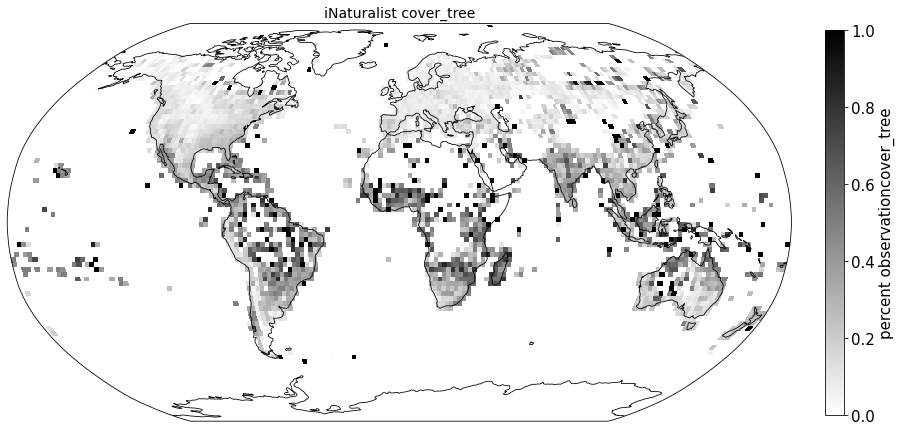

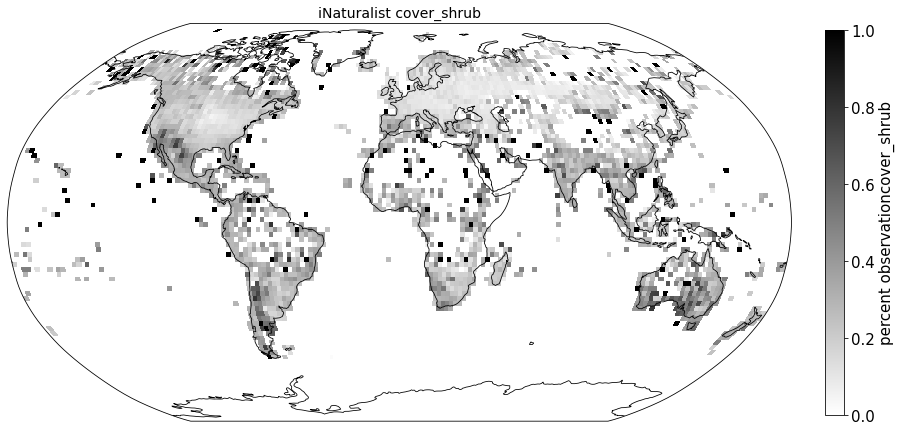

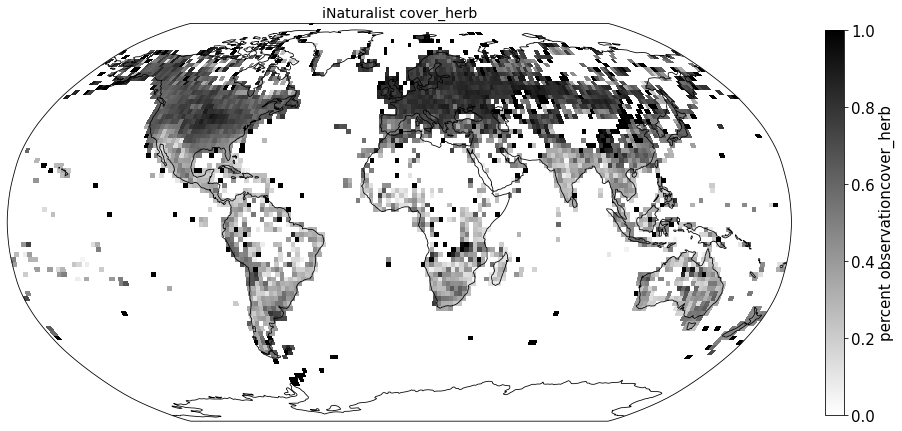

In [23]:
for lf in ['cover_tree', 'cover_shrub', 'cover_herb']:
    data_iNat_TRY = grouped_all.pivot('y_bin', 'x_bin', lf)
# data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels_iNat = MaxNLocator(nbins=15).tick_values(grouped_all[lf].min(), grouped_all[lf].max())
    cmap = plt.get_cmap('gist_yarg')
    norm = BoundaryNorm(levels_iNat, ncolors=cmap.N, clip=True)
    im_ratio = data_iNat_TRY.shape[0]/data_iNat_TRY.shape[1]

    #plot map
    fig = plt.figure(figsize=(15, 15)) # I created a new figure and set up its size

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
    
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, data_iNat_TRY, cmap="gist_yarg", 
                   vmin=grouped_all[lf].min(),
                  vmax=grouped_all[lf].max(),
                      transform=data_crs) 
    
    #add color bar
    label= 'percent observation' + lf
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label )

    #add coastlines
    ax.coastlines(resolution='110m', color='black', linewidth=0.8)

    #set title
    ax.set_title( "iNaturalist " + lf, size=14)
    
    filename = '../Figures/iNat_' + lf[0:4] + '_cover.pdf'
    plt.savefig(filename, bbox_inches='tight')  

   


## Compare to sPlot life form coverage

In [24]:
sPlot_cover = pd.read_csv("sPlotOpen/splot_cover_v1.csv") 

In [25]:
sPlot_cover

,PlotObservationID,lat,long,cover_tree,cover_shrub,cover_herb
0,16.0,62.420000,-154.180000,0.000000,0.000000,1.000000
1,17.0,62.420000,-154.180000,0.000000,0.000000,1.000000
2,18.0,62.420000,-154.180000,0.000000,0.000000,1.000000
3,20.0,62.420000,-154.180000,0.000000,0.000000,1.000000
4,22.0,62.420000,-154.180000,0.000000,0.025641,0.974359
...,...,...,...,...,...,...
95099,1126749.0,56.287870,27.273862,0.000000,0.142857,0.857143
95100,1126761.0,56.939965,23.598014,0.000000,0.010526,0.989474
95101,1126769.0,56.939965,23.598014,0.005025,0.045226,0.949749
95102,1126774.0,57.248222,22.147667,0.038462,0.230769,0.730769


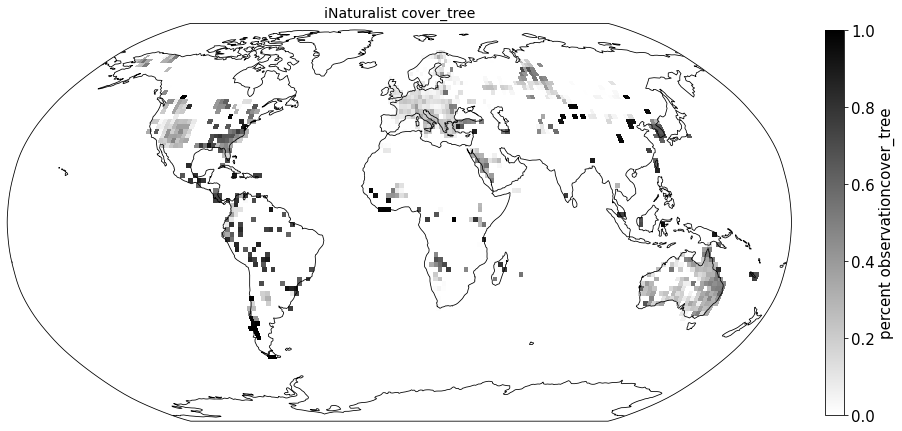

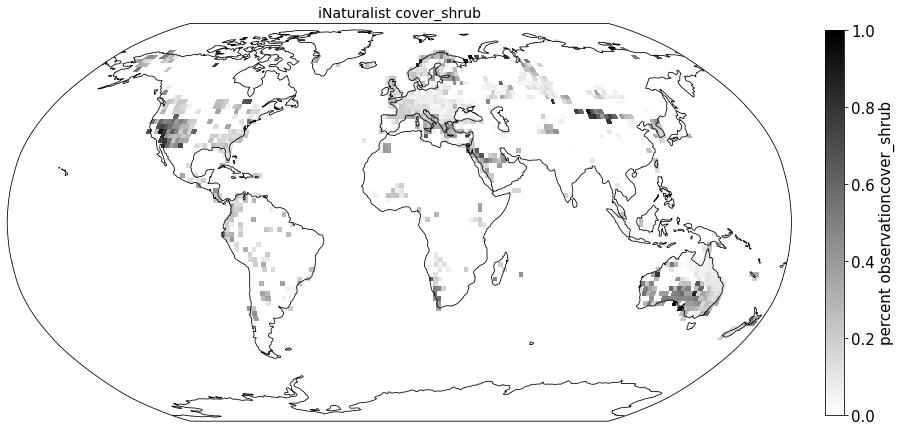

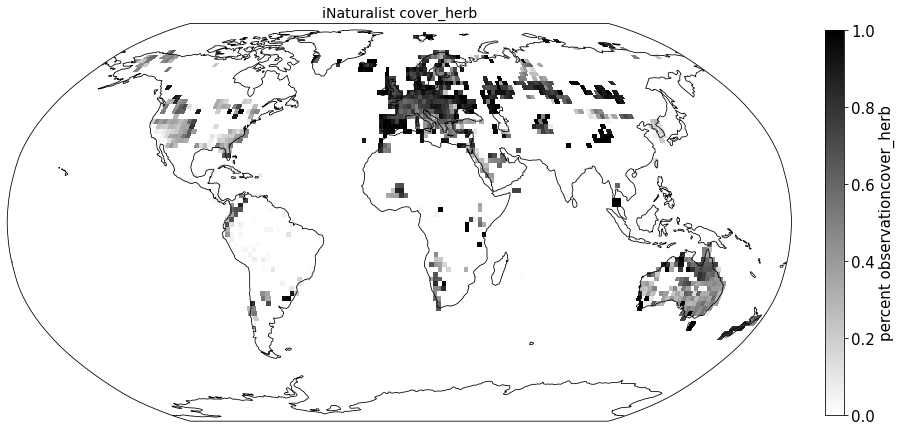

In [26]:
plt.rcParams.update({'font.size': 15})

step = 181

bins_x = np.linspace(-180,180,step) 
bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
sPlot_cover['x_bin'] = pd.cut(sPlot_cover['long'], bins=bins_x)
sPlot_cover['y_bin'] = pd.cut(sPlot_cover['lat'], bins=bins_y)
sPlot_cover['x_bin'] = sPlot_cover['x_bin'].apply(lambda x: x.left)
sPlot_cover['y_bin'] = sPlot_cover['y_bin'].apply(lambda x: x.left)


for lf in ['cover_tree', 'cover_shrub', 'cover_herb']:

    sPlot_raster = sPlot_cover.groupby(['x_bin', 'y_bin'], as_index=False)[lf].mean()
    sPlot_lf_p = sPlot_raster.pivot('y_bin', 'x_bin', lf)
    # data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels= MaxNLocator(nbins=15).tick_values(sPlot_cover[lf].min(), sPlot_cover[lf].max())
    cmap = plt.get_cmap('gist_yarg')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im_ratio = sPlot_lf_p.shape[0]/sPlot_lf_p.shape[1]

    #plot map
    fig = plt.figure(figsize=(15, 15)) # I created a new figure and set up its size

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
    
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, sPlot_lf_p, cmap="gist_yarg", 
                   vmin=sPlot_raster[lf].min(),
                  vmax=sPlot_raster[lf].max(),
                      transform=data_crs) 
    
    #add color bar
    label= 'percent observation' + lf
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label )

    #add coastlines
    ax.coastlines(resolution='110m', color='black', linewidth=0.8)

    #set title
    ax.set_title( "iNaturalist " + lf, size=14)
    
    filename = '../Figures/sPlot_' + lf + '_cover.pdf'
    plt.savefig(filename, bbox_inches='tight')  

   




In [27]:
sPlot_raster = sPlot_cover.groupby(['x_bin', 'y_bin'], as_index=False)['cover_tree'].mean()

for lf in ['cover_shrub', 'cover_herb']:

    sPlot_raster[lf] = sPlot_cover.groupby(['x_bin', 'y_bin'], as_index=False)[lf].mean()[lf]

In [28]:
sPlot_raster

,x_bin,y_bin,cover_tree,cover_shrub,cover_herb
0,-180.0,-90.0,NaN,NaN,NaN
1,-180.0,-88.0,NaN,NaN,NaN
2,-180.0,-86.0,NaN,NaN,NaN
3,-180.0,-84.0,NaN,NaN,NaN
4,-180.0,-82.0,NaN,NaN,NaN
...,...,...,...,...,...
16195,178.0,80.0,NaN,NaN,NaN
16196,178.0,82.0,NaN,NaN,NaN
16197,178.0,84.0,NaN,NaN,NaN
16198,178.0,86.0,NaN,NaN,NaN


cover_tree 0.20960458938750362
cover_shrub 0.11001097795490279
cover_herb 0.19741552527140613


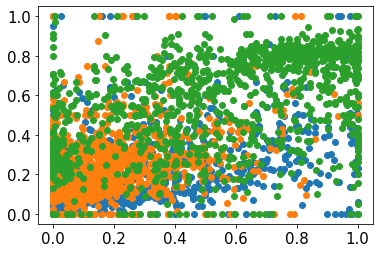

In [29]:
for lf in ['cover_tree', 'cover_shrub', 'cover_herb']:
    sPlot_raster[lf] = sPlot_cover.groupby(['x_bin', 'y_bin'], as_index=False)[lf].mean()[lf]
    plt.scatter(sPlot_raster[lf],grouped_all[lf])
        
    correlation_xy = sPlot_raster[lf].corr(grouped_all[lf])
    print(lf + " " + str(correlation_xy**2))

In [30]:
iNat_melt = pd.melt(grouped_all, id_vars=['x_bin','y_bin'], 
        value_vars=["cover_tree","cover_shrub","cover_herb"],
        value_name= "iNat coverage")

In [31]:
sPlot_melt = pd.melt(sPlot_raster, id_vars=['x_bin','y_bin'], 
        value_vars=["cover_tree","cover_shrub","cover_herb"],
        value_name= "sPlot coverage")

In [32]:
raster = pd.merge(iNat_melt, sPlot_melt, on=['x_bin','y_bin', 'variable'])

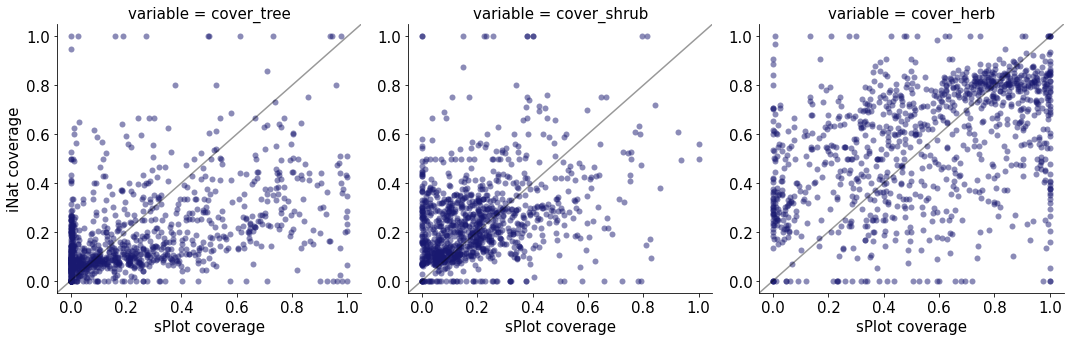

In [33]:
g = sns.relplot(
    data=raster,
    x="sPlot coverage", y="iNat coverage",
    col="variable", 
    kind="scatter", 
    col_wrap=4, 
    linewidth=0,
    alpha=0.5,
    color="midnightblue",
    palette='crest',
    facet_kws={'sharey': False, 'sharex': False}
)

for traits, ax in g.axes_dict.items():

    ax.axline([0, 0], [1, 1], color= "black", alpha=0.4)



### Over biomes 

In [34]:
iNat_with_biome = pd.read_csv("iNat_biomes.csv")

In [35]:
iNat_with_biome.head()

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length,BIOME
0,1990599612,Macaranga tanarius,23.122994,120.534961,2019-01-25T14:51:00,2019-01-27T13:49:07,NaN,10.997687,2.848944,NaN,...,NaN,1.064711,2.183426,3.427650,NaN,NaN,NaN,-0.785087,NaN,1.0
1,1990599668,Adiantum capillus-veneris,23.123053,120.536422,2019-01-25T15:36:00,2019-01-27T14:22:54,NaN,4.088585,4.030621,NaN,...,NaN,-1.021651,-1.213114,-1.890699,NaN,NaN,NaN,NaN,NaN,1.0
2,1978441599,Chloris barbata,23.123362,120.183891,2018-12-16T17:21:58,2018-12-16T13:14:40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.565953,NaN,NaN,NaN,NaN,NaN,1.0
3,1883470731,Adiantum capillus-veneris,23.123363,120.536638,2018-03-11T11:48:00,2018-07-07T12:43:18,NaN,4.088585,4.030621,NaN,...,NaN,-1.021651,-1.213114,-1.890699,NaN,NaN,NaN,NaN,NaN,1.0
4,2242806671,Dioscorea bulbifera,23.123399,120.533835,2019-04-28T10:44:00,2019-05-03T12:45:18,NaN,5.093750,3.785888,NaN,...,NaN,NaN,NaN,1.736951,NaN,NaN,NaN,NaN,NaN,1.0


1.0
cover_tree 0.01943613258365132
cover_shrub 0.028058360539673456
cover_herb 0.0022278128815516945
2.0
cover_tree 0.00495158098325045
cover_shrub 0.0021841156153433973
cover_herb 0.0017625094597744017
3.0
cover_tree 0.27454095391406436
cover_shrub 0.02880357026669633
cover_herb 0.004831038955014629
4.0
cover_tree 0.259079820611657
cover_shrub 0.006749994097072907
cover_herb 0.23471860018958288
5.0
cover_tree 0.0902670010518872
cover_shrub 0.07357112645012613
cover_herb 0.17702590884327152
6.0
cover_tree 0.015465784550899028
cover_shrub 0.014347538706417832
cover_herb 0.010721767313240553
7.0
cover_tree 0.003077455550975538
cover_shrub 2.643230909102668e-05
cover_herb 0.018979266464673905
8.0
cover_tree 0.019313094032917352
cover_shrub 0.1095073129145167
cover_herb 0.13137953769498106
9.0
cover_tree 1.9096182179645747e-05
cover_shrub 0.16424750138680017
cover_herb 0.12904371358220107
10.0
cover_tree 0.015454822638076557
cover_shrub 0.00029106358542621644
cover_herb 0.04854474044738274

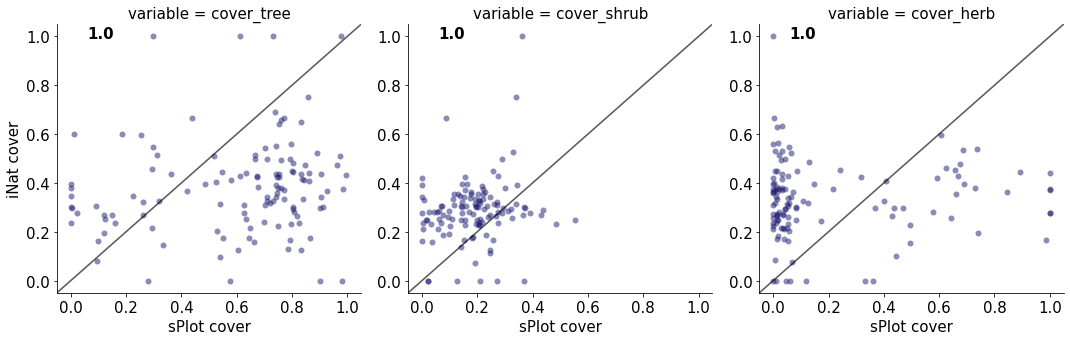

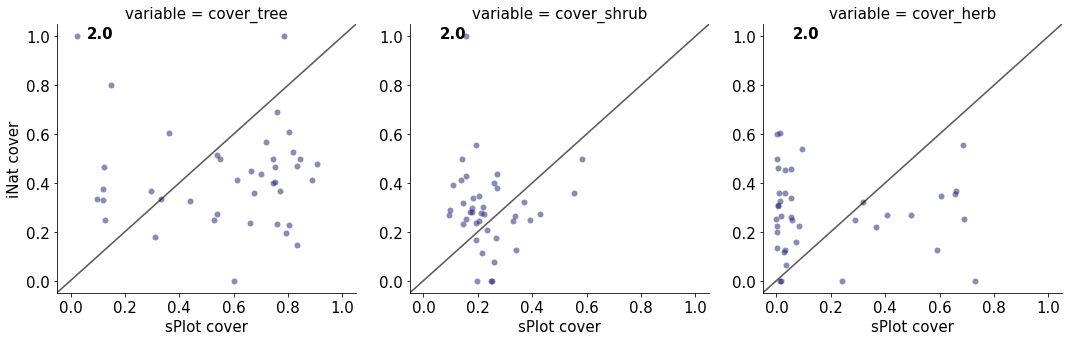

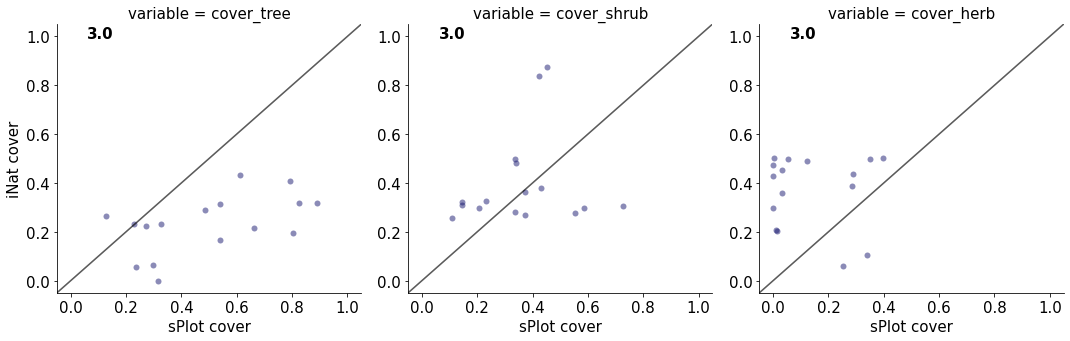

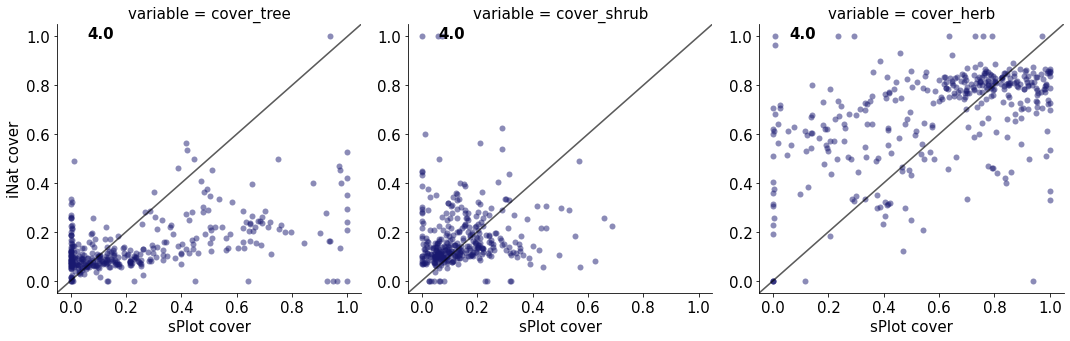

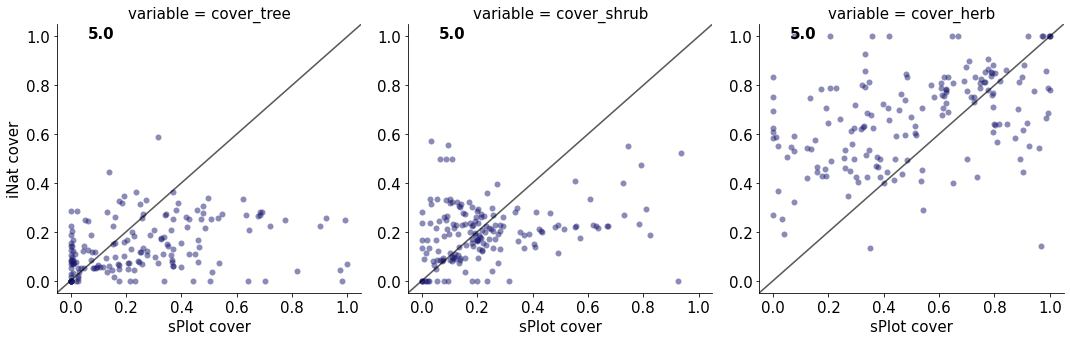

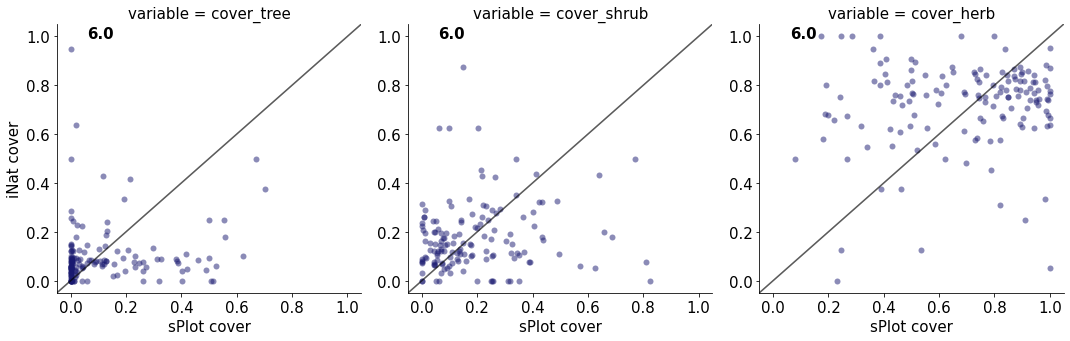

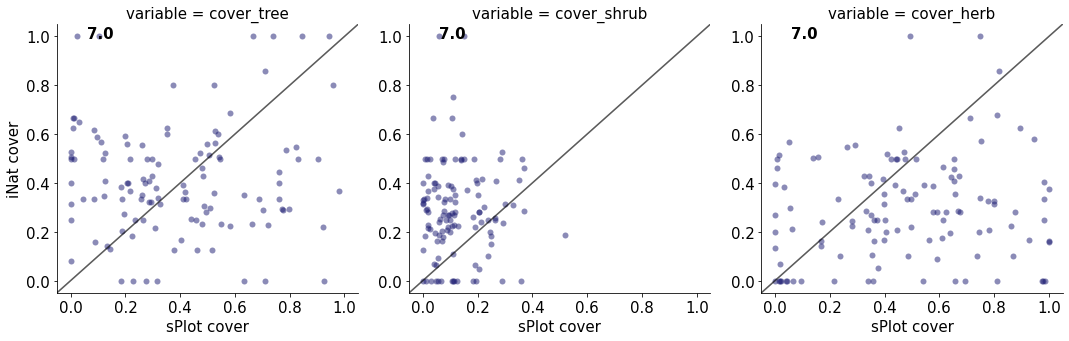

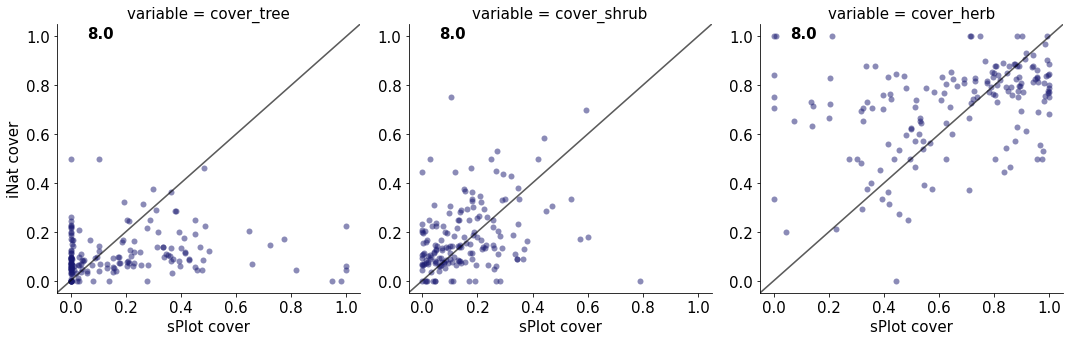

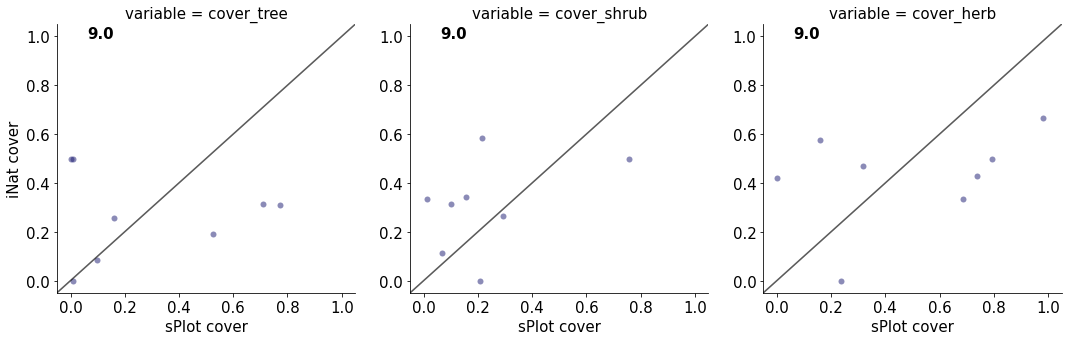

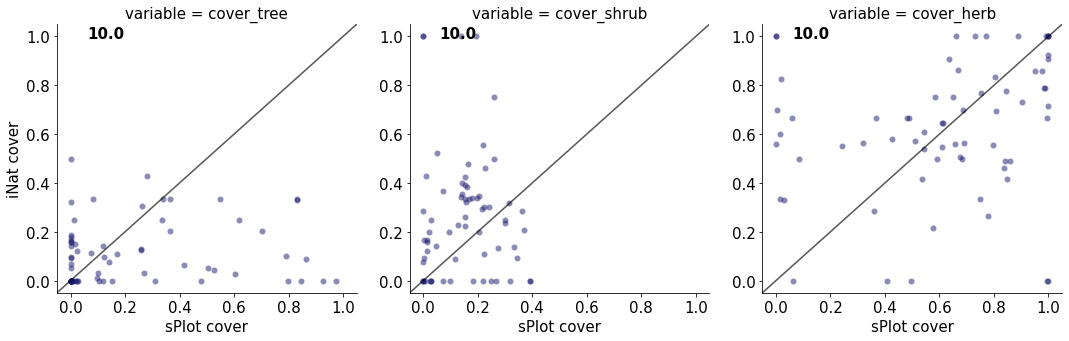

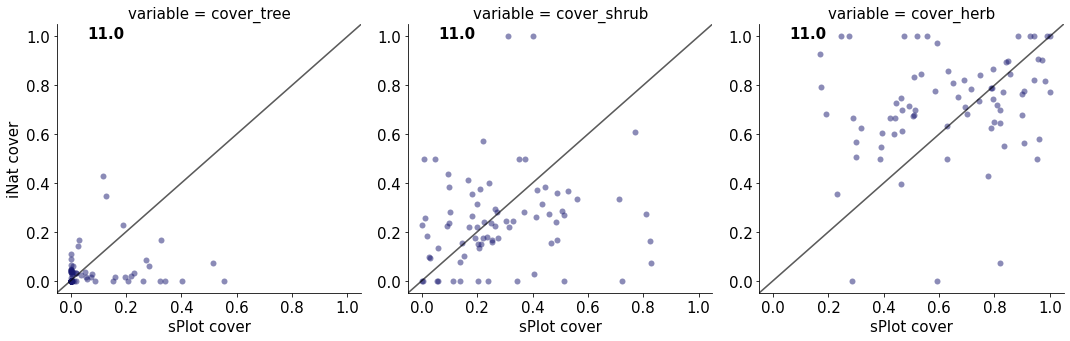

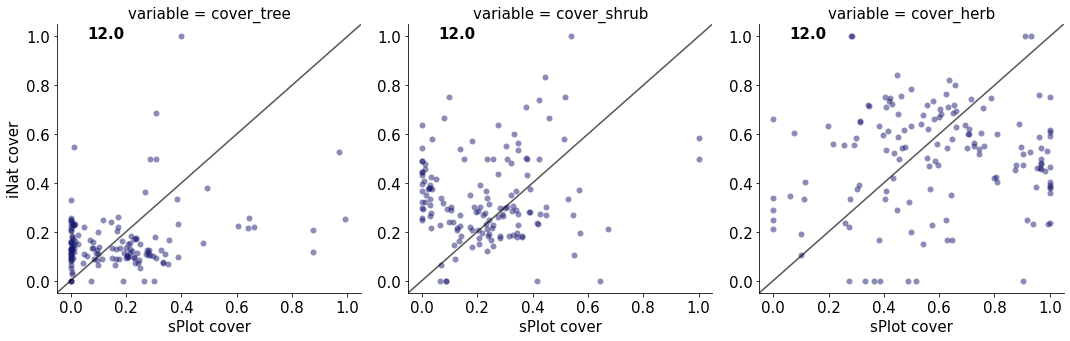

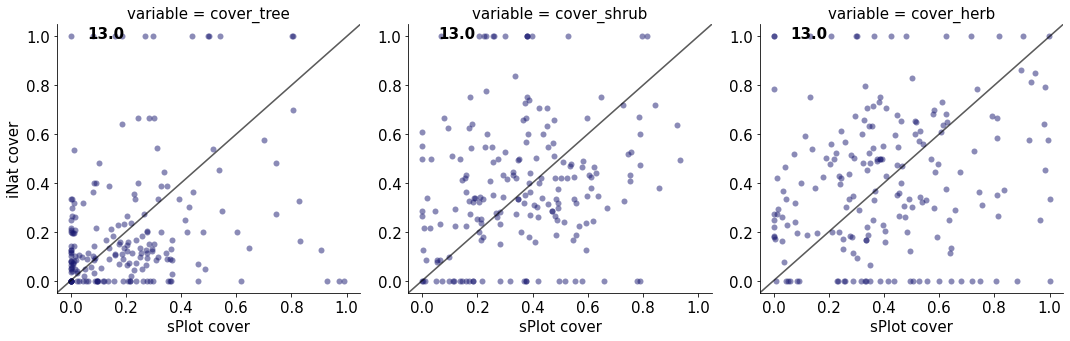

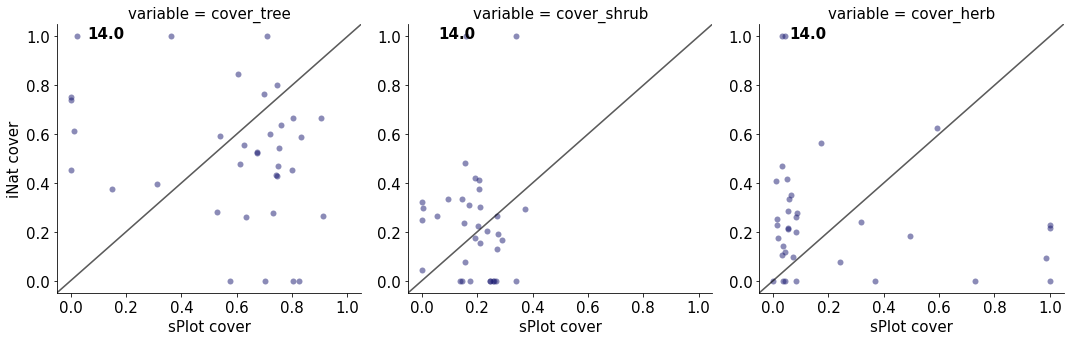

In [40]:
biomes = list(iNat_with_biome['BIOME'].unique())

for b in biomes:

    sub_iNat_with_biome = iNat_with_biome[iNat_with_biome["BIOME"]==b]

    iNat_lf = pd.merge(sub_iNat_with_biome, growth_forms_sum, on='scientificName', how='inner')
    iNat_lf['life form'] = iNat_lf[["is_tree", "is_shrub", "is_herb"]].idxmax(axis="columns")
    iNat_lf = iNat_lf[iNat_lf["life form"].notna()]

    plt.rcParams.update({'font.size': 15})

    step = 181

    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
    iNat_lf['x_bin'] = pd.cut(iNat_lf['decimalLongitude'], bins=bins_x)
    iNat_lf['y_bin'] = pd.cut(iNat_lf['decimalLatitude'], bins=bins_y)
    iNat_lf['x_bin'] = iNat_lf['x_bin'].apply(lambda x: x.left)
    iNat_lf['y_bin'] = iNat_lf['y_bin'].apply(lambda x: x.left)

    iNat_tree = iNat_lf[iNat_lf['life form']== "is_tree"]
    iNat_shrub = iNat_lf[iNat_lf['life form']== "is_shrub"]
    iNat_herb = iNat_lf[iNat_lf['life form']== "is_herb"]

    grouped_all = iNat_lf.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()

    grouped_trees = iNat_tree.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()
    grouped_shrubs = iNat_shrub.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()
    grouped_herbs = iNat_herb.groupby(['x_bin', 'y_bin'], as_index=False)['life form'].size()

    grouped_all['cover_tree'] = grouped_trees['size']/grouped_all['size']
    grouped_all['cover_shrub'] = grouped_shrubs['size']/grouped_all['size']
    grouped_all['cover_herb'] = grouped_herbs['size']/grouped_all['size']
    
    # print correlation

    print(b)

    for lf in ['cover_tree', 'cover_shrub', 'cover_herb']:
        sPlot_raster[lf] = sPlot_cover.groupby(['x_bin', 'y_bin'], as_index=False)[lf].mean()[lf]        
        correlation_xy = sPlot_raster[lf].corr(grouped_all[lf])
        print(lf + " " + str(correlation_xy**2))
    
    iNat_melt = pd.melt(grouped_all, id_vars=['x_bin','y_bin'], 
        value_vars=["cover_tree","cover_shrub","cover_herb"],
        value_name= "iNat cover")
    sPlot_melt = pd.melt(sPlot_raster, id_vars=['x_bin','y_bin'], 
        value_vars=["cover_tree","cover_shrub","cover_herb"],
        value_name= "sPlot cover")
    
    raster = pd.merge(iNat_melt, sPlot_melt, on=['x_bin','y_bin', 'variable'])
    
    g = sns.relplot(
    data=raster,
    x="sPlot cover", y="iNat cover",
    col="variable", 
    #hue="NumberiNatObservations", 
    #size="NumberiNatObservations",
    kind="scatter", 
    #hue="Weights",
    col_wrap=4, 
    #aspect = 1,  height = 4,
    linewidth=0,
    alpha=0.5,
    color="midnightblue",
    palette='crest',
    facet_kws={'sharey': False, 'sharex': False})
    
    index=0
    for traits, ax in g.axes_dict.items():
        ax.axline([0, 0], [1, 1], color= "black", alpha=0.4)
        # Iterate over each subplot to customize further

        trait_title= b
        # Add the title as an annotation within the plot
        ax.text(.1, .95, trait_title, transform=ax.transAxes, fontweight="bold")
        index+=1
        ax.axline([0, 0], [1, 1], color= "black", alpha=0.4)


    
    filename = '../Figures/corr_biome' + str(b) + '_cover.pdf'
    plt.savefig(filename, bbox_inches='tight')  
